In [13]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis
import cmocean as cmo
import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
from defs import oht_amoc_anomaly
import scipy

## Figure 10: MMM changes in total OHT, overturning OHT and gyre OHT

In [14]:
#Exclude HadGEM3 from model list to calculate MMM 
folder = '/Volumes/External/DataPlioMIP2/Data/Processed/'
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F']#, 'HadGEM3']

In [15]:
lats = np.arange(-34, 65) #All OHT interpolated to 1deg latitude increments

dsE280 = xr.Dataset(data_vars = dict(Htot=(["model", "lats"], np.zeros([len(modellist),len(lats)])), Hov=(["model", "lats"], np.zeros([len(modellist),len(lats)])), Haz=(["model", "lats"], np.zeros([len(modellist),len(lats)]))), coords = dict(model = modellist, lats = lats))
dsEoi400 = dsE280.copy(deep=True)

for i in range(len(modellist)):
    model = modellist[i]
    ds1 = xr.open_dataset(folder+model+'/E280/decomOHT_100yr.nc')
    dsE280.Hov[i,:]= ds1.OHTov.interp(lat=lats, method='linear')
    dsE280.Haz[i,:]= ds1.OHTaz.interp(lat=lats, method='linear')
    
    ds1 = xr.open_dataset(folder+model+'/E280/OHT_100yr.nc')
    dsE280.Htot[i,:]= ds1.OHT.interp(lat=lats, method='linear')
    
    ds2 = xr.open_dataset(folder+model+'/Eoi400/decomOHT_100yr.nc')
    dsEoi400.Hov[i,:]= ds2.OHTov.interp(lat=lats, method='linear')
    dsEoi400.Haz[i,:]= ds2.OHTaz.interp(lat=lats, method='linear')
    
    ds2 = xr.open_dataset(folder+model+'/Eoi400/OHT_100yr.nc')
    dsEoi400.Htot[i,:]= ds2.OHT.interp(lat=lats, method='linear')
    
mmmE280_Hov = dsE280.Hov.mean(dim='model')
mmmEoi400_Hov = dsEoi400.Hov.mean(dim='model')
std_ov = (dsEoi400.Hov-dsE280.Hov).std(dim='model')

mmmE280_Haz = dsE280.Haz.mean(dim='model')
mmmEoi400_Haz = dsEoi400.Haz.mean(dim='model')
std_az = (dsEoi400.Haz-dsE280.Haz).std(dim='model')

mmmE280_Htot = dsE280.Htot.mean(dim='model')
mmmEoi400_Htot = dsEoi400.Htot.mean(dim='model')
std_tot = (dsEoi400.Htot-dsE280.Htot).std(dim='model')

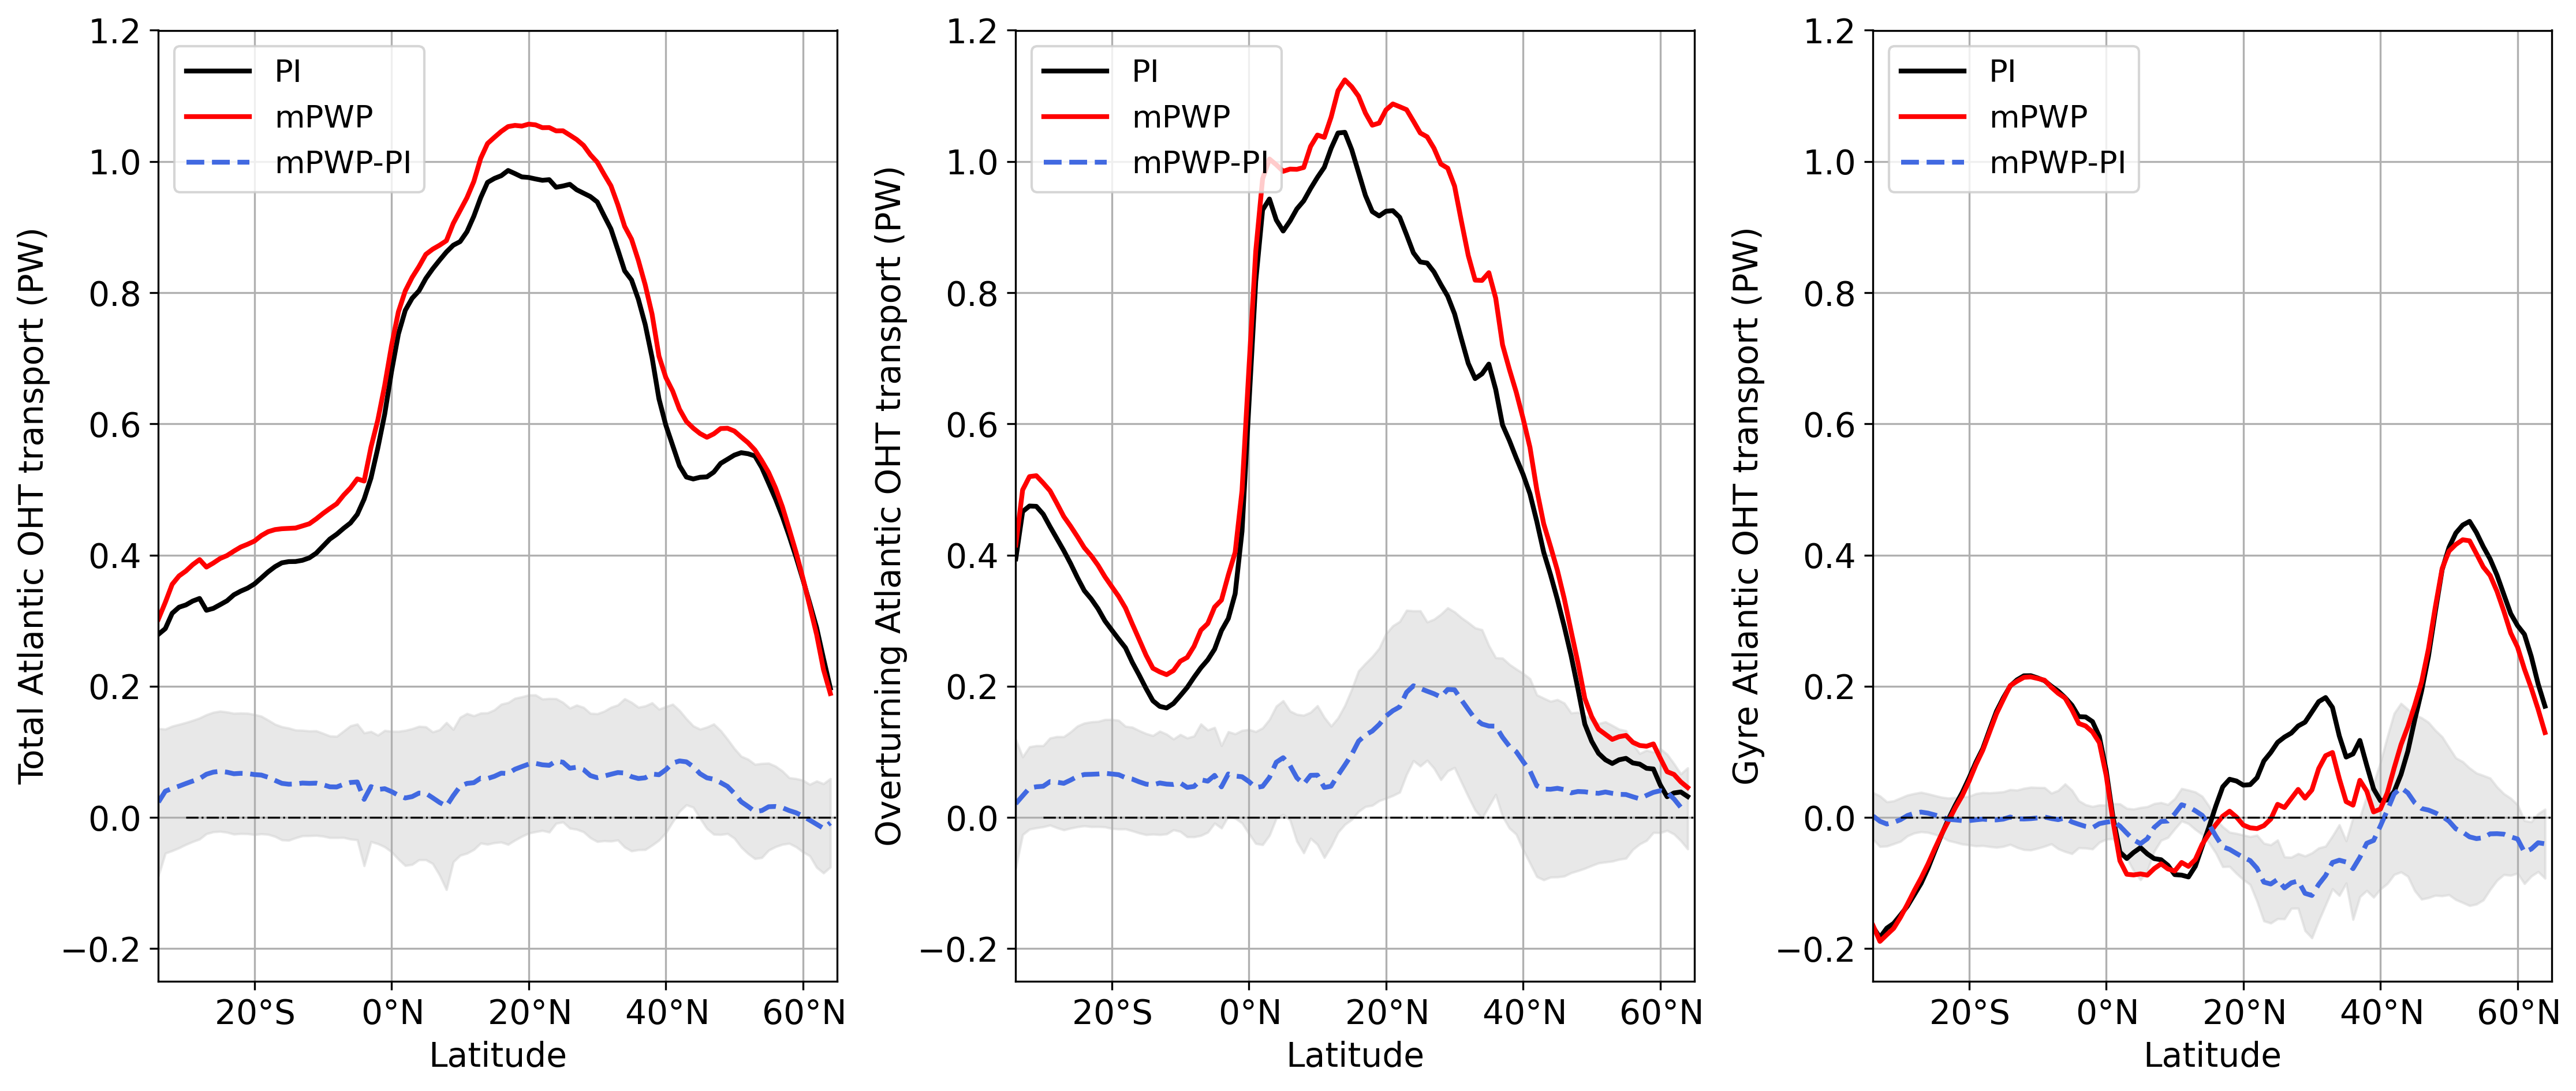

In [16]:
x_pos = np.array([-20,0,20,40,60])
xtext = ('20$\degree$S', '0$\degree$N', '20$\degree$N', '40$\degree$N', '60$\degree$N')

fig1, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6.4), dpi=300)

ax[1].plot(lats, mmmE280_Hov, color='black',linewidth = 2, label='PI')
ax[1].plot(lats, mmmEoi400_Hov, color='red',linewidth = 2, label='mPWP')
ax[1].plot(lats, mmmEoi400_Hov-mmmE280_Hov, color='royalblue', linewidth =2, linestyle='--', label='mPWP-PI')
ax[1].fill_between(lats, (mmmEoi400_Hov-mmmE280_Hov)-std_ov, (mmmEoi400_Hov-mmmE280_Hov)+std_ov, color='lightgrey', alpha=0.5)

ax[2].plot(lats, mmmE280_Haz, color='black',linewidth = 2, label='PI')
ax[2].plot(lats, mmmEoi400_Haz, color='red',linewidth = 2, label='mPWP')
ax[2].plot(lats, mmmEoi400_Haz-mmmE280_Haz, color='royalblue', linewidth =2, linestyle='--', label='mPWP-PI')
ax[2].fill_between(lats, (mmmEoi400_Haz-mmmE280_Haz)-std_az, (mmmEoi400_Haz-mmmE280_Haz)+std_az, color='lightgrey', alpha=0.5)

ax[0].plot(lats, mmmE280_Htot, color='black',linewidth = 2, label='PI')
ax[0].plot(lats, mmmEoi400_Htot, color='red',linewidth = 2, label='mPWP')
ax[0].plot(lats, mmmEoi400_Htot-mmmE280_Htot, color='royalblue', linewidth =2, linestyle='--',label='mPWP-PI')
ax[0].fill_between(lats, (mmmEoi400_Htot-mmmE280_Htot)-std_tot, (mmmEoi400_Htot-mmmE280_Htot)+std_tot, color='lightgrey', alpha=0.5)

for j in range(3):
    ax[j].legend(fontsize=13, loc='upper left')
    ax[j].plot([-30, 80],[0,0], color='black',linewidth=0.8, linestyle='-.')
    ax[j].set_xlim([-34, 65])
    ax[j].set_ylim([-0.25, 1.2])
    ax[j].set_xticks(x_pos)
    ax[j].set_xticklabels(xtext,fontsize=14)
    ax[j].set_xlabel('Latitude', fontsize=14)
    ax[j].grid(True)
    #plt.setp(ax[j].get_xticklabels(), fontsize=16)
    plt.setp(ax[j].get_yticklabels(), fontsize=14)

ax[1].set_ylabel('Overturning Atlantic OHT transport (PW)', fontsize=14)
ax[2].set_ylabel('Gyre Atlantic OHT transport (PW)', fontsize=14)
ax[0].set_ylabel('Total Atlantic OHT transport (PW)', fontsize=14)
fig1.tight_layout()
plt.savefig('fig10.png', bbox_inches='tight')

In [17]:
#Maximum increase in OHT
dif = mmmEoi400_Htot-mmmE280_Htot
print(dif.where(dif.lats==24, drop=True).squeeze())

#Percentage increase at 24degN
print(dif.where(dif.lats==24)/mmmE280_Htot.where(dif.lats==24, drop=True)*100)

print('30S-60N average increase in OHT')
print(dif.where(dif.lats>=-30).where(dif.lats<=60).mean())
print(dif.where(dif.lats>=-30).where(dif.lats<=60).mean()/mmmE280_Htot.where(dif.lats>=-30).where(dif.lats<=60).mean()*100)

print('20-40N average increase in OHT')
print(dif.where(dif.lats>=20).where(dif.lats<=40).mean())
print(dif.where(dif.lats>=20).where(dif.lats<=40).mean()/mmmE280_Hov.where(dif.lats>=20).where(dif.lats<=40).mean()*100)

<xarray.DataArray 'Htot' ()>
array(0.08595963)
Coordinates:
    lats     int64 24
<xarray.DataArray 'Htot' (lats: 1)>
array([8.9473523])
Coordinates:
  * lats     (lats) int64 24
30S-60N average increase in OHT
<xarray.DataArray 'Htot' ()>
array(0.05348253)
<xarray.DataArray 'Htot' ()>
array(8.38581995)
20-40N average increase in OHT
<xarray.DataArray 'Htot' ()>
array(0.07111224)
<xarray.DataArray ()>
array(9.47205521)


In [18]:
#Maximum increase in OHT by overturning
dif = mmmEoi400_Hov-mmmE280_Hov
print(dif.where(dif==dif.max(), drop=True))

#Percentage increase at 24degN
print(dif.where(dif.lats==24)/mmmE280_Hov.where(dif.lats==24, drop=True)*100)

print('30S-60N average increase in OHT')
print(dif.where(dif.lats>=-30).where(dif.lats<=60).mean())
print(dif.where(dif.lats>=-30).where(dif.lats<=60).mean()/mmmE280_Hov.where(dif.lats>=-30).where(dif.lats<=60).mean()*100)

print('20-40N average increase in OHT')
print(dif.where(dif.lats>=20).where(dif.lats<=40).mean())
print(dif.where(dif.lats>=20).where(dif.lats<=40).mean()/mmmE280_Hov.where(dif.lats>=20).where(dif.lats<=40).mean()*100)

<xarray.DataArray 'Hov' (lats: 1)>
array([0.20072536])
Coordinates:
  * lats     (lats) int64 24
<xarray.DataArray 'Hov' (lats: 1)>
array([23.31972185])
Coordinates:
  * lats     (lats) int64 24
30S-60N average increase in OHT
<xarray.DataArray 'Hov' ()>
array(0.08156856)
<xarray.DataArray 'Hov' ()>
array(15.8044319)
20-40N average increase in OHT
<xarray.DataArray 'Hov' ()>
array(0.15995547)
<xarray.DataArray 'Hov' ()>
array(21.30585355)


In [19]:
#Maximum decrease in OHT by gyre
dif = mmmEoi400_Haz-mmmE280_Haz
print(dif.where(dif==dif.min(), drop=True))

#Percentage at 30degN (max decrease latitude)
print(dif.where(dif==dif.min(), drop=True)/mmmE280_Hov.where(dif==dif.min(), drop=True)*100)

print(dif.where(dif.lats==24,drop=True))
#Percentage at 24degN
print(dif.where(dif.lats==24)/mmmE280_Hov.where(dif.lats==24, drop=True)*100)

<xarray.DataArray 'Haz' (lats: 1)>
array([-0.11892886])
Coordinates:
  * lats     (lats) int64 30
<xarray.DataArray (lats: 1)>
array([-15.48949359])
Coordinates:
  * lats     (lats) int64 30
<xarray.DataArray 'Haz' (lats: 1)>
array([-0.10149206])
Coordinates:
  * lats     (lats) int64 24
<xarray.DataArray (lats: 1)>
array([-11.79106941])
Coordinates:
  * lats     (lats) int64 24


## Figure: individual model scatter plot total OHT & overturning OHT against AMOC strength

In [20]:
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

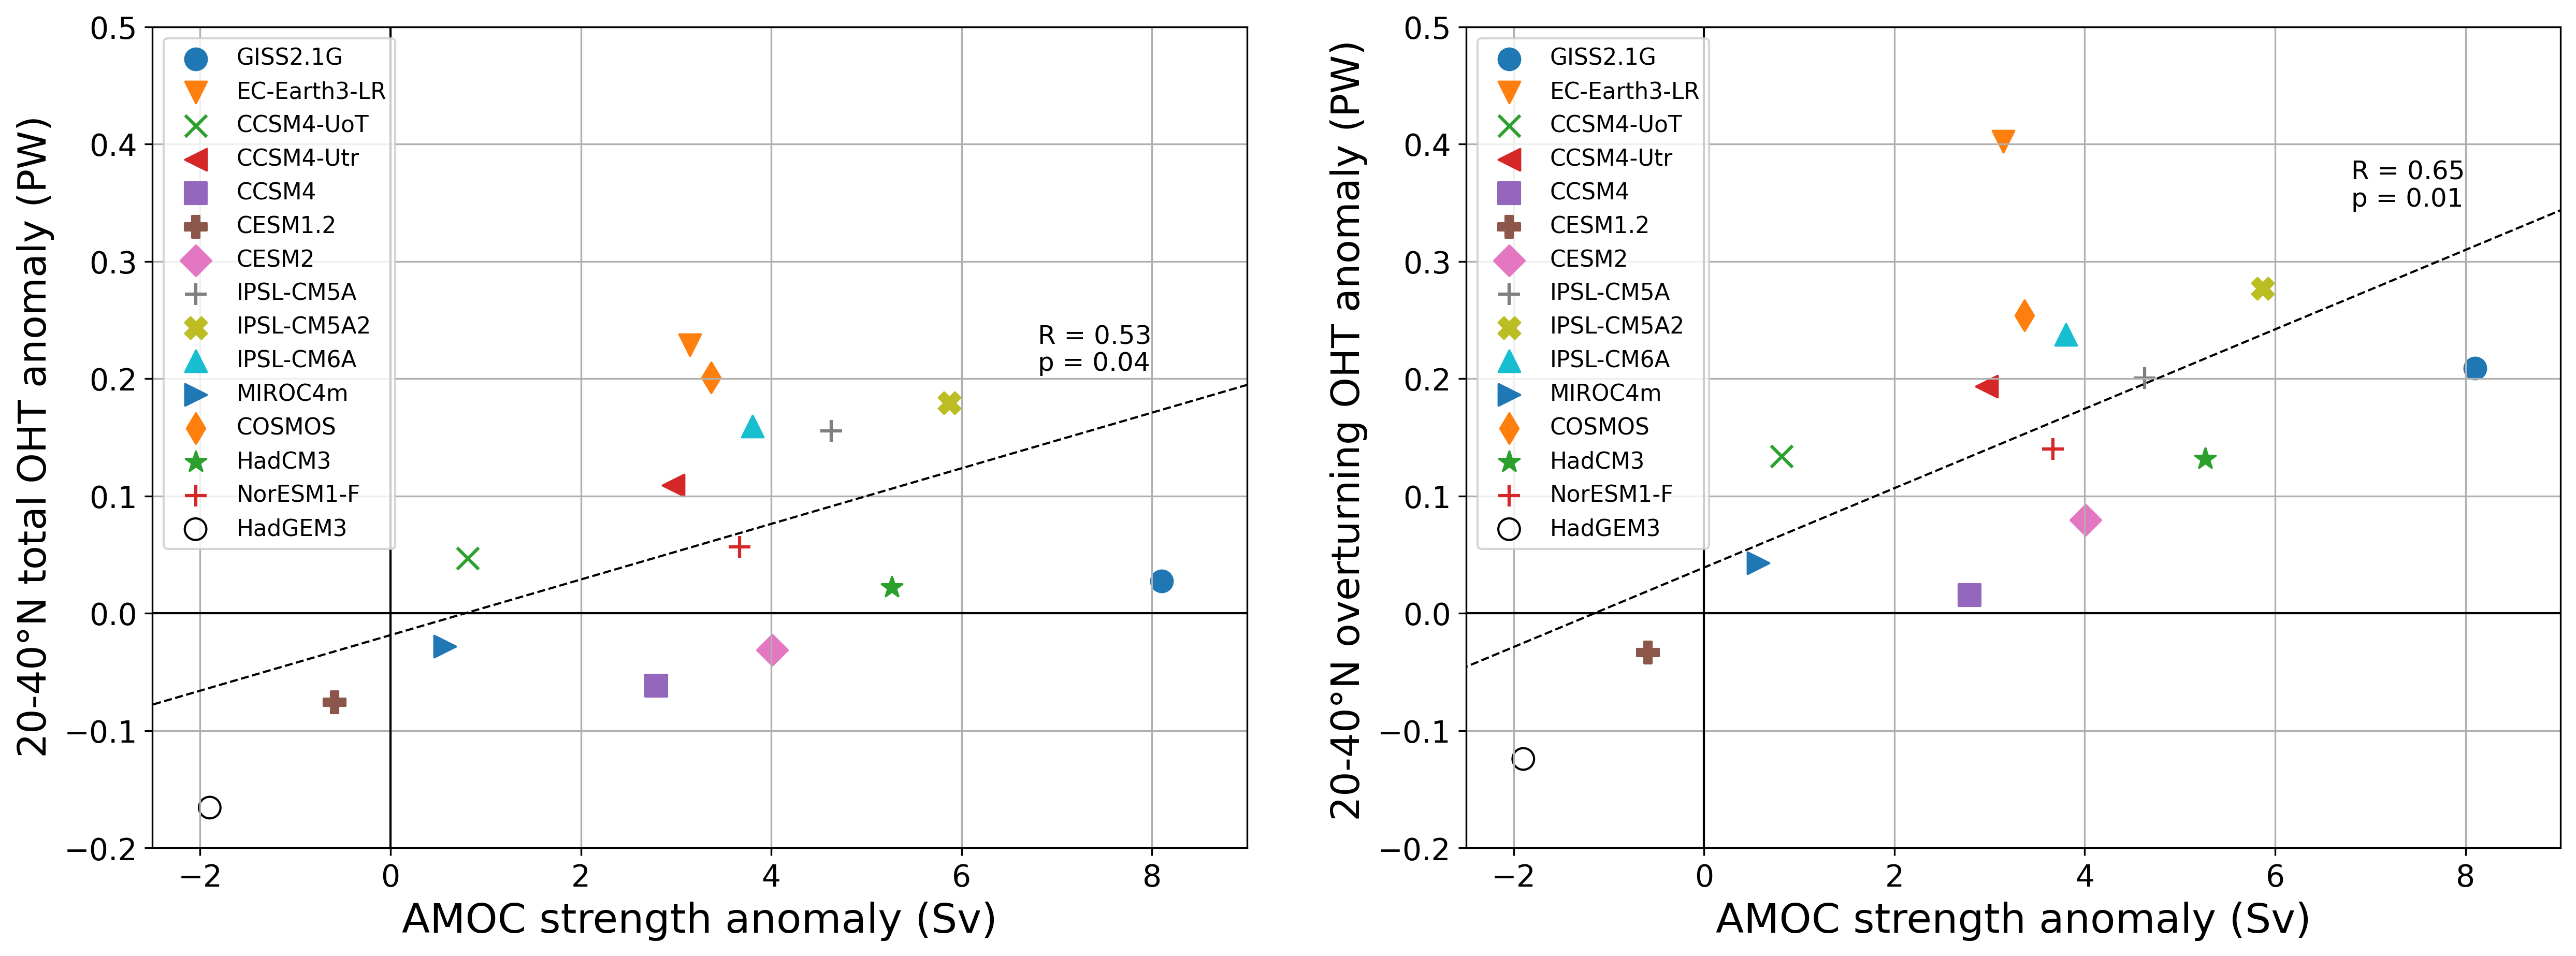

In [21]:
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelsize'] = 19

latmin = 20
latmax = 40
difamoc, difov, difoht = oht_amoc_anomaly(modellist, latmin, latmax)

x = np.arange(-5,10,0.1)

markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
fig, ax = plt.subplots(1, 2, figsize=(20,7), dpi=300)

#Perform linear regression between AMOC anomaly and total/overturning OHT anomaly
p = scipy.stats.linregress(difamoc, difoht)
p1 = scipy.stats.linregress(difamoc, difov)

for j in range(0,len(modellist)-1):
    scatter = ax[0].scatter(difamoc[j], difoht[j], s=100, c = 'C'+str(j), label=modellist[j], marker=markers[j])
    scatter2 = ax[1].scatter(difamoc[j], difov[j], s=100, c='C'+str(j), label=modellist[j], marker=markers[j])

ax[0].scatter(difamoc[-1], difoht[-1], s=100, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])
ax[1].scatter(difamoc[-1], difov[-1], s=100, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])

ax[0].plot(x, x*p[0]+p[1], color='black',linewidth =1, linestyle ='--')    
ax[0].text(6.8,0.23,'R = %.2f' %(p[2]), fontsize=12)
ax[0].text(6.8,0.207,'p = %.2f' %(p[3]), fontsize=12)
ax[1].plot(x, x*p1[0]+p1[1], color='black',linewidth =1, linestyle ='--')
ax[1].text(6.8,0.37,'R = %.2f' %(p1[2]), fontsize=12)
ax[1].text(6.8,0.347,'p = %.2f' %(p1[3]), fontsize=12)

for i in range(0,2):
    ax[i].plot([-30, 60], [0, 0], color='black',linewidth =1, linestyle ='-')
    ax[i].plot([0, 0], [-50, 150], color='black',linewidth =1, linestyle ='-')
    ax[i].set_xlim([-2.5, 9])
    ax[i].set_ylim([-0.2, 0.5])
    ax[i].set_xlabel('AMOC strength anomaly (Sv)')

ax[0].legend(loc='upper left', fontsize=10.5)
ax[1].legend(loc='upper left', fontsize=10.5)
ax[0].grid()
ax[1].grid()

ax[0].set_ylabel(r'20-40$\degree$N total OHT anomaly (PW)', fontsize=18)
ax[1].set_ylabel(r' 20-40$\degree$N overturning OHT anomaly (PW)', fontsize=18)
#ax[0].set_title('(a)', loc = 'left', fontsize=14)
#ax[1].set_title('(b)', loc='left', fontsize=14)

plt.savefig('fig11.png', bbox_inches='tight')

In [22]:
#Change order of modellist to be able to exclude EC-Earth3-LR for regressions
modellist =  ['EC-Earth3-LR', 'GISS2.1G','CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

In [23]:
#Regressions 20-40N
latmin = 20
latmax = 40
difamoc, difov, difoht = oht_amoc_anomaly(modellist, latmin, latmax)

print(scipy.stats.linregress(difamoc, difoht))
print(scipy.stats.linregress(difamoc, difoht)[2]**2)
print(scipy.stats.linregress(difamoc, difov))
print(scipy.stats.linregress(difamoc, difov)[2]**2)
#Excluding EC-Earth3-LR
print(scipy.stats.linregress(difamoc[1:], difoht[1:]))
print(scipy.stats.linregress(difamoc[1:], difoht[1:])[2]**2)
print(scipy.stats.linregress(difamoc[1:], difov[1:]))
print(scipy.stats.linregress(difamoc[1:], difov[1:])[2]**2)

LinregressResult(slope=0.023703807099095805, intercept=-0.018623421394258252, rvalue=0.5256705505595929, pvalue=0.04416354643504748, stderr=0.01063905874630774)
0.2763295277256255
LinregressResult(slope=0.03385179425094833, intercept=0.03894508843710891, rvalue=0.6490941388049283, pvalue=0.00883707115340214, stderr=0.011003234383547382)
0.4213232010309115
LinregressResult(slope=0.023617366541945687, intercept=-0.030698262559780573, rvalue=0.5761082624266718, pvalue=0.031066908926024657, stderr=0.009672912108680532)
0.33190073003627896
LinregressResult(slope=0.03372334257956262, intercept=0.021001734292192473, rvalue=0.7654155997607407, pvalue=0.0014202284360188883, stderr=0.008184944259853713)
0.5858610403570944


In [24]:
#Regressions 30S-40N
latmin = -30
latmax = 60
difamoc, difov, difoht = oht_amoc_anomaly(modellist, latmin, latmax)

print(scipy.stats.linregress(difamoc, difoht))
print(scipy.stats.linregress(difamoc, difoht)[2]**2)
print(scipy.stats.linregress(difamoc, difov))
print(scipy.stats.linregress(difamoc, difov)[2]**2)
#Excluding EC-Earth3-LR
print(scipy.stats.linregress(difamoc[1:], difoht[1:]))
print(scipy.stats.linregress(difamoc[1:], difoht[1:])[2]**2)
print(scipy.stats.linregress(difamoc[1:], difov[1:]))
print(scipy.stats.linregress(difamoc[1:], difov[1:])[2]**2)

LinregressResult(slope=0.018238203431508435, intercept=-0.013958662727120673, rvalue=0.5031842237582315, pvalue=0.055873559106353624, stderr=0.00868734675748424)
0.253194363039174
LinregressResult(slope=0.020500735970644744, intercept=0.006381394056521217, rvalue=0.5751347250865594, pvalue=0.02489445238002559, stderr=0.008087469534450923)
0.33077995200039223
LinregressResult(slope=0.01817422475160976, intercept=-0.022895814721811514, rvalue=0.5429613057231281, pvalue=0.04481477150781221, stderr=0.00811428754157498)
0.2948069795125641
LinregressResult(slope=0.020409452380989155, intercept=-0.006369968063875631, rvalue=0.6887957290113108, pvalue=0.0064435715089370856, stderr=0.006200998392739648)
0.47443955630422313
